# Домашнее задание 3. Детекция объектов



Сыграем в квиддич? Или лучше в карты?



В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.



Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.



Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.



Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.





Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)



### А ещё есть консультация 2023 года :)



https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes



Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(



По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.



Отдельная благодарность А. Абрамову за написание assert для проверки функций и В. Гилязову за поясняющую картинку.

## Данные



Скачайте один из датасетов на свой вкус и начните работу с ним.

Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment

#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip



# Cards -- uncomment

!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

!unzip -q data.zip

--2024-11-19 20:46:07--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2024-11-19 20:46:07--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2024-11-19 20:46:07 (255 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.



Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch

from xml.etree import ElementTree as ET

import albumentations as A

from albumentations.pytorch.transforms import ToTensorV2

from pathlib import Path

import glob

import numpy as np

from PIL import Image

import torchvision

from torchvision.models import ResNet50_Weights

from tqdm.notebook import tqdm

from torch import nn

import shutil

import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
# https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
# где взял код

def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):

    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]

    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()

    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.

        class_int = class_dict[member.find("name").text]
        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(member.find("bndbox/ymin").text)
        xmin = int(member.find("bndbox/xmin").text)
        ymax = int(member.find("bndbox/ymax").text)
        xmax = int(member.find("bndbox/xmax").text)

        res =  [xmin, ymin, xmax, ymax, class_int]
        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"
        self.filenames = np.array(glob.glob(root + "/images/*"))

        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}
        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],

    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)


test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.



Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.



В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.





Полезные функции:

* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure

* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)

* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images, bboxes):

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)
        if i >= len(images):
            break

        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        image = images[i].permute(1, 2, 0).cpu().numpy()
        image = (image * std + mean).clip(0, 1)

        # Вот тут покажите картинку после отката нормализации
        ax.imshow(image)

        for bbox in bboxes[i]:
          xmin, ymin, xmax, ymax, class_int = bbox
          label = train_ds.class_dict_inv[class_int]

          # Рисуем прямоугольники
          rect = Rectangle(
              (xmin, ymin), xmax - xmin, ymax - ymin,
              linewidth=2, edgecolor='g', facecolor='none'
          )

          ax.add_patch(rect)
          # Добавляем текст метки
          ax.text(
              xmin, ymin - 5, label,
              color="red", fontsize=10, bbox=dict(facecolor='white', alpha=0.5)
          )

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

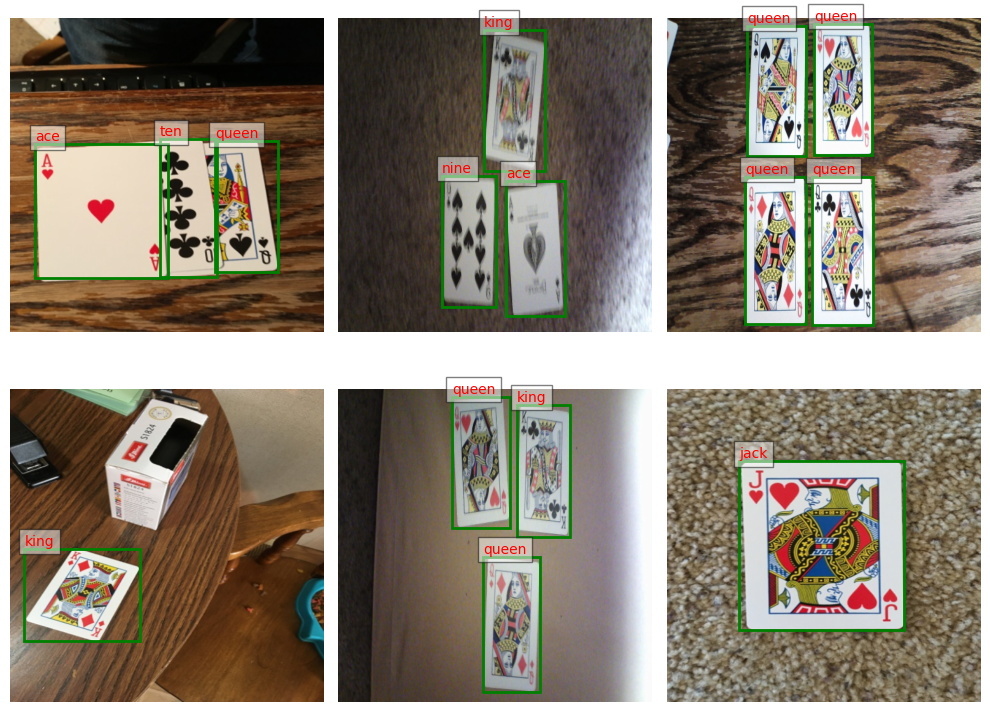

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.

## YOLO-like детектор



Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.



Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).



Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код.



В шести "каналах" у нас будут записаны:

* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)

* Нормализованные ширина и высота bbox. 2 канала (W, H)

* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал

* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.



Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)



![image](https://i.imgur.com/13YVxAd.jpeg)

In [9]:
def collate_fn(batch, downsample=32):

    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )


        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box =  (xmax - xmin) / w
        h_box =  (ymax - ymin) / h

        # Посчитайте координаты центра и сдвиги
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2

        cx_idx = (cx // downsample).long()
        cy_idx = (cy // downsample).long()

        cx_box = (cx % downsample) / downsample
        cy_box = (cy % downsample) / downsample

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [10]:
def test_collate_fn() -> None:

    target1 = [ 100, 200, 200, 300, 2 ] # xmin, ymin, xmax, ymax, class
    target2_1 = [ 0, 250, 200, 300, 0 ] # xmin, ymin, xmax, ymax, class
    target2_2 = [ 0, 100, 100, 300, 1 ] # xmin, ymin, xmax, ymax, class

    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target1 ] },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target2_1, target2_2 ] }
    ])

    # Проверяем размерности
    assert result['image'].shape == (2, 3, 512, 512)
    assert result['target'].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(result['target'][0, :, 7, 4], torch.tensor([ 22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2 ]))
    assert np.allclose(result['target'][1, :, 8, 3], torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))
    assert np.allclose(result['target'][1, :, 6, 1], torch.tensor([ 18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1 ]))

    # Проверяем, что все остальные клеточки содержат нули
    result['target'][0, :, 7, 4] = result['target'][1, :, 8, 3] = result['target'][1, :, 6, 1] = torch.zeros(6)
    assert np.allclose(result['target'], 0)

test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

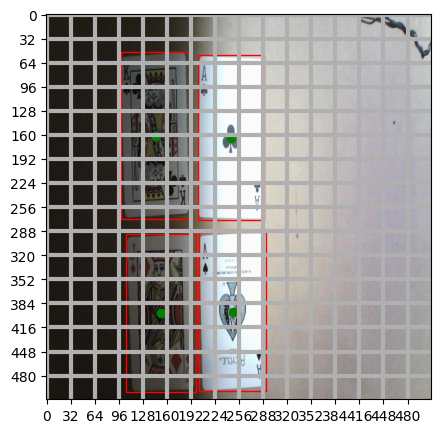

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)

bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)

loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")
plt.show()

## Задача 3.2. 0.5 балла.



Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему?



Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.



Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.



То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.



Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [12]:
def decode_prediction(pred, upsample=32, threshold=0.7):

    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    if c > 6:
      # берем первые 5 каналов
      five_channels = pred[:, :5, :, :]

      # берем каналы классов
      class_channels = pred[:, 5:, :, :]

      # выделяем самый вероятный класс, будет табличка 16*16 для каждого батча
      prediction = torch.argmax(class_channels, dim=1).unsqueeze(1)
      pred = torch.concat([five_channels, prediction], dim=1)

    decoded_boxes = []

    # можно конечно попробовать векторами, но будто будет очень неприятно делать..
    for i in range(b):

      boxes = []
      for y in range(h):
        for x in range(w):
          cx_offset, cy_offset, w_box, h_box, confidence, class_id = pred[i, :, y, x]

          if confidence < threshold:
              continue

          cx = (x + cx_offset) * upsample
          cy = (y + cy_offset) * upsample

          width = w_box * img_w
          height = h_box * img_h

          xmin = cx - width / 2
          ymin = cy - height / 2
          xmax = cx + width / 2
          ymax = cy + height / 2

          boxes.append([int(xmin.item()), int(ymin.item()), int(xmax.item()), int(ymax.item()), int(class_id.item())])

      decoded_boxes.append(boxes)

    return decoded_boxes

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [13]:
def test_decode_predictions() -> None:

    # Применяем collate_fn к некоторым данным
    target1 = [ [ 100, 200, 200, 300, 2 ] ]
    target2 = [ [ 0, 250, 200, 300, 0 ], [ 0, 100, 100, 300, 1 ] ]

    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target1 },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target2 }
    ])



    target = result['target']
    assert target.shape == (2, 6, 16, 16)

    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов

    target = torch.cat([ target, torch.zeros(2, 2, 16, 16) ], dim = 1) # Добавляем два канала
    assert target.shape == (2, 8, 16, 16) # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([ 0.5, 0.6, 0.9 ]) # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([ 0.9, 0.6, 0.5 ]) # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([ 0.6, 0.9, 0.5 ]) # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print('Actual:  ', actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [ target1, [ target2[1], target2[0] ] ]

    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print('Expected:', expected)

    # Сравниваем
    assert actual == expected

test_decode_predictions()

Actual:   [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.

Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.



Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [14]:
from torchvision.models import ResNet152_Weights

C = len(train_ds.class_dict)

class Detector(nn.Module):
    def __init__(self):
        super().__init__()

        # model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        model = torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT)

        self.feature_extractor = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        for name, param in self.feature_extractor.named_parameters():
            if "layer4" not in name :
                param.requires_grad = False

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=3, padding = 1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding = 1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=5 + C, kernel_size=3, padding = 1),
            torch.nn.Sigmoid()
        )

    def forward(self, img):
        x = self.feature_extractor(img)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        return x

## Задача 3.4. 0.5 балла.



Реализуйте функцию потерь.



Для этого:

* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)

* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)

    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект

    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект

    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу

    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)





* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [15]:
def special_loss(pred, target, C=C):

    mask = target[:, 4, :, :] > 0 # делаем маску с помощью confidence

    # берем cx cy, то есть наши сдвиг
    shift_mse_x = nn.functional.mse_loss(
        torch.masked_select(pred[:, 0, :, :], mask),
        torch.masked_select(target[:, 0, :, :], mask),
        reduction='sum'
    )

    shift_mse_y = nn.functional.mse_loss(
        torch.masked_select(pred[:, 1, :, :], mask),
        torch.masked_select(target[:, 1, :, :], mask),
        reduction='sum'
    )

    # теперь считаем лосс для W и H бибокса
    mse_W = nn.functional.mse_loss(
        torch.masked_select(pred[:, 2, :, :], mask) ** 0.5,
        torch.masked_select(target[:, 2, :, :], mask) ** 0.5,
        reduction='sum'
    )

    mse_H = nn.functional.mse_loss(
        torch.sqrt(torch.masked_select(pred[:, 3, :, :], mask)),
        torch.sqrt(torch.masked_select(target[:, 3, :, :], mask)),
        reduction='sum'
    )

    # теперь нужно посчитать classifictaion loss, будем работать по идее из консы
    pred_classes = pred[:, 5:5 + C, :, :]
    target_classes = target[:, 5, :, :]


    # [B, C, H, W] -> [B, H, W, C]
    pred_classes_masked = torch.masked_select(pred_classes.permute(0, 2, 3, 1), mask.unsqueeze(-1)).view(-1, C)

    target_classes_masked = torch.masked_select(target_classes, mask).long()
    classification_loss_fn = nn.CrossEntropyLoss(reduction='sum')
    classification_loss = classification_loss_fn(pred_classes_masked, target_classes_masked)

    # теперь лосс для объектов ненулевых и нулевых
    bce = nn.BCELoss(reduction='sum')
    confidence_loss_obj = bce(
        torch.masked_select(pred[:, 4, :, :], mask),
        torch.masked_select(target[:, 4, :, :], mask)
    )

    confidence_loss_noobj = bce(
        torch.masked_select(pred[:, 4, :, :], ~mask),
        torch.masked_select(target[:, 4, :, :], ~mask)
    )

    localization_loss = shift_mse_x + shift_mse_y
    box_loss = mse_W + mse_H
    confidence_loss = confidence_loss_obj + 0.05 * confidence_loss_noobj

    # попытался поподбирать коэффы, эти лучше всех себя показали
    return 1 * localization_loss + 2.5 * box_loss + 1.5 * classification_loss + 1 * confidence_loss

# Задача 4. 2 балла.



Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [16]:
loader = torch.utils.data.DataLoader(train_ds, 1, collate_fn=collate_fn, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  20 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)


for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []

    for batch in pbar:
        image, target = batch['image'].to(device), batch['target'].to(device)

        y_pred = model(image)
        loss = special_loss(y_pred, target)
        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 111MB/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 0 done; Train loss 6.904;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 1 done; Train loss 4.827;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2 done; Train loss 4.185;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 3 done; Train loss 3.900;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 4 done; Train loss 3.767;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 5 done; Train loss 3.696;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 6 done; Train loss 3.691;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 7 done; Train loss 3.619;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 8 done; Train loss 3.563;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 9 done; Train loss 3.653;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 10 done; Train loss 3.482;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 11 done; Train loss 3.258;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 12 done; Train loss 3.144;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 13 done; Train loss 3.030;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 14 done; Train loss 3.007;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 15 done; Train loss 3.012;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 16 done; Train loss 3.010;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 17 done; Train loss 2.995;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 18 done; Train loss 2.981;


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 19 done; Train loss 2.976;


Запустим обученный детектор на тестовых изображениях:

In [18]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [19]:
# Нужно сделать предсказание и переложить результат на cpu
images, targets = batch['image'].to(device), batch['target'].to(device)
pred = model(images).to(device)

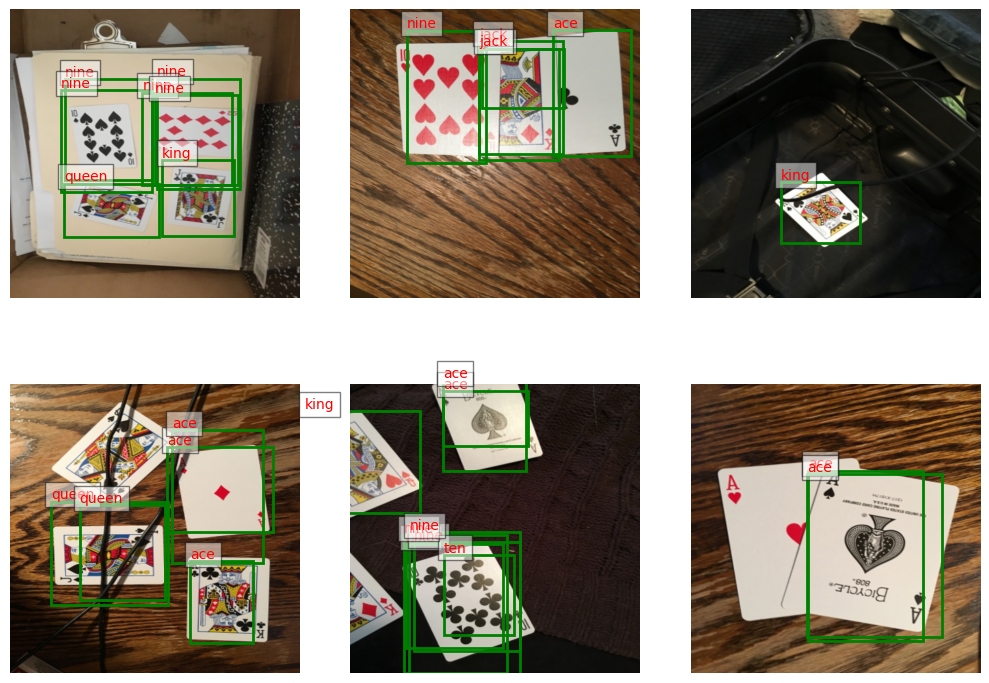

In [27]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
visualize(images.detach().cpu(), decode_prediction(pred.detach().cpu(), threshold=0.05))

Последнее обучение получилось довольно плохим, до этого было лучше(получалось отличать джокеры), сейчас видимо плохо зарандомило

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.



Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.



Для этого будем использовать YOLO 11 от ultralytics.

In [21]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 24.7 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.



Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).



Если коротко:

* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия

* Есть папочки train valid (их поможем вам собрать), в них две подпапки:

    - Первая images, в ней лежат картинки

    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [22]:
# Делаем папочки

!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.



Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [23]:
def annotation2txt(bboxes, w_im, h_im):
    yolo_annotations = []

    for bbox in bboxes:
        class_id = str(bbox[4])
        center_x = str((bbox[0] + bbox[2]) / (2 * w_im))
        center_y = str((bbox[1] + bbox[3]) / (2 * h_im))
        box_width = str((bbox[2] - bbox[0]) / w_im)
        box_height = str((bbox[3] - bbox[1]) / h_im)

        annotation_line = f"{class_id} {center_x} {center_y} {box_width} {box_height}"
        yolo_annotations.append(annotation_line)

    return yolo_annotations


In [24]:
# Копируем картиночки по папочкам и создаем txt файлики
for i in range(len(train_ds)):

    result = train_ds.__get_raw_item__(i)
    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)
    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [25]:
nc = len(train_ds.class_dict) # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(train_ds.class_dict.keys()) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:

    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.



Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.



Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)



Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):



https://github.com/ultralytics/ultralytics/issues/1149



https://github.com/ultralytics/yolov5/issues/6907



https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [28]:
import ultralytics

model = ultralytics.YOLO('yolo11n.yaml', verbose=False)
model.train(data='data.yaml', epochs=100, batch=16, imgsz=512, verbose=False)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.yaml, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=Fal

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.3MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 1665.41it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 7 corrupt: 100%|██████████| 37/37 [00:00<00:00, 930.06it/s]

val: WARNING ⚠️ /content/valid/images/cam_image14.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0701]
val: WARNING ⚠️ /content/valid/images/cam_image21.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1574]
val: WARNING ⚠️ /content/valid/images/cam_image22.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.082]
val: WARNING ⚠️ /content/valid/images/cam_image35.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3704      1.3717]
val: WARNING ⚠️ /content/valid/images/cam_image37.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5013      1.5093]
val: WARNING ⚠️ /content/valid/images/cam_image47.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.6204      1.0344      1.6045      1.0622]
val: WARNING ⚠️ /content/valid/images/cam_image5.jpg: ignoring corrupt image/label

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.99G      3.187      4.522      4.388         32        512: 100%|██████████| 21/21 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

                   all         30         60    0.00131      0.201    0.00266   0.000439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.96G      3.166      4.393      4.097         18        512: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         30         60    0.00125      0.185    0.00122   0.000244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.96G      2.956      4.097      3.835         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         30         60    0.00103       0.15    0.00114   0.000216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.97G      2.947      3.793      3.583         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         30         60   0.000809      0.109    0.00115   0.000203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.98G      2.865      3.699      3.428         17        512: 100%|██████████| 21/21 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         30         60    0.00238      0.342     0.0143     0.0041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.95G      2.766      3.459      3.226         20        512: 100%|██████████| 21/21 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         30         60     0.0211      0.176     0.0273     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.97G      2.684      3.407      3.151         18        512: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         30         60      0.143     0.0851     0.0708     0.0283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.96G       2.48      3.187       2.97         29        512: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         30         60      0.168      0.369       0.16     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.95G      2.277      2.918      2.788         16        512: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         60     0.0843      0.263      0.116     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.97G      2.154      2.855      2.713         29        512: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         30         60      0.295      0.249      0.304      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.97G      2.022      2.702      2.575         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         30         60      0.247      0.326      0.244      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.96G       1.93      2.608      2.484         24        512: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         30         60      0.405      0.432      0.359      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.95G      1.855      2.506      2.392         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         30         60      0.376      0.532       0.41       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.99G      1.694      2.389      2.277         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         30         60      0.334      0.514      0.379      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.95G      1.703      2.338      2.208         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all         30         60      0.496      0.546      0.484      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.96G      1.556      2.167      2.109         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         30         60      0.425      0.581      0.511      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.98G       1.46      2.156      2.006         24        512: 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         30         60      0.537      0.579      0.554      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.96G      1.484      2.097      2.016         30        512: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         30         60      0.333      0.629      0.557      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.97G      1.426      2.057      1.945         20        512: 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         30         60      0.492      0.514      0.509      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.99G      1.385      2.028      1.938         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         30         60      0.571      0.608      0.555      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.95G      1.428      2.004      1.956         24        512: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         60      0.782       0.47      0.646      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.97G      1.326      1.963       1.86         43        512: 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         30         60       0.48      0.695      0.581      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.96G      1.333      1.959      1.865         17        512: 100%|██████████| 21/21 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         30         60      0.531       0.79      0.608      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.97G      1.304      1.877        1.8         26        512: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         30         60      0.462      0.644      0.596      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.98G      1.306      1.914      1.843         27        512: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         30         60      0.446      0.629      0.581      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.96G      1.276      1.864      1.777         26        512: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         30         60      0.482      0.679      0.619      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.96G      1.213      1.794      1.749         31        512: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         30         60      0.506      0.802       0.63      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.95G      1.182      1.754      1.699         34        512: 100%|██████████| 21/21 [00:06<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         30         60      0.589      0.703      0.665      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.98G      1.196      1.731      1.707         30        512: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         30         60      0.542       0.63      0.646      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.99G      1.161      1.679      1.674         24        512: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         30         60      0.467      0.638        0.6      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.97G      1.158      1.716      1.671         29        512: 100%|██████████| 21/21 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         30         60      0.648      0.589      0.676      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.96G      1.164      1.682      1.677         28        512: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         30         60      0.659      0.673      0.693      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.94G      1.069      1.615      1.584         20        512: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         30         60      0.498      0.831      0.661      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.99G      1.076       1.62      1.588         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         30         60      0.628       0.63      0.683      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.99G      1.078      1.587      1.595         25        512: 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         30         60      0.494      0.766      0.712      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.97G      1.103      1.596      1.624         17        512: 100%|██████████| 21/21 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         30         60      0.491      0.872      0.716      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.96G      1.131      1.646      1.619         34        512: 100%|██████████| 21/21 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         30         60      0.688      0.645      0.725      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.96G      1.102      1.602      1.607         25        512: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         30         60      0.551      0.696      0.721      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.96G       1.03      1.535       1.53         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         30         60      0.679      0.691      0.715      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.97G      1.052      1.543      1.556         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         30         60      0.579      0.684      0.683      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.95G      1.031      1.529      1.546         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         30         60      0.565      0.844      0.728      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.99G      1.013      1.482      1.514         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         30         60      0.583      0.665      0.611      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.97G     0.9946      1.483      1.499         37        512: 100%|██████████| 21/21 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         30         60      0.771      0.669      0.746      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.96G     0.9647      1.476       1.48         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         30         60      0.704      0.667      0.754      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.98G     0.9936      1.467      1.505         18        512: 100%|██████████| 21/21 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         30         60        0.7      0.737      0.724      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.97G     0.9562      1.423       1.48         18        512: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         30         60      0.578      0.816      0.765      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.99G     0.9561       1.42      1.479         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         30         60      0.506      0.609      0.603      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.97G     0.9479       1.41      1.466         33        512: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         30         60      0.613      0.744      0.715      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.96G     0.9277      1.376       1.42         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         30         60        0.7       0.73      0.739      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.96G     0.9774      1.433      1.482         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         30         60      0.581       0.82       0.74      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.99G     0.9509      1.376      1.463         25        512: 100%|██████████| 21/21 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         30         60      0.673      0.784      0.789       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.97G     0.9338      1.357       1.45         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         30         60      0.681      0.735      0.743      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.95G     0.9175      1.378      1.424         18        512: 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         30         60      0.721      0.695      0.759      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.97G     0.9104      1.339      1.426         13        512: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         30         60      0.631      0.832      0.788       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.96G     0.8853      1.309      1.396         35        512: 100%|██████████| 21/21 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         30         60      0.778      0.697      0.812      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.97G     0.8699      1.282      1.395         28        512: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         30         60       0.65       0.88      0.774      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.95G     0.9114      1.306      1.424         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         30         60      0.744      0.689      0.794       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.96G     0.9011      1.279      1.402         21        512: 100%|██████████| 21/21 [00:05<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30         60      0.732      0.726      0.799      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.97G     0.8708      1.238      1.387         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         30         60      0.745      0.783      0.775      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.97G     0.8572      1.268      1.386         29        512: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         30         60      0.734      0.735      0.778      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.95G     0.8208      1.261       1.35         18        512: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         30         60       0.71      0.831      0.803      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.96G     0.8484      1.228      1.365         31        512: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         30         60      0.668      0.894      0.779      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.99G      0.879      1.259      1.385         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         30         60      0.665       0.83      0.808      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.97G     0.8554      1.273      1.373         25        512: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         30         60       0.71        0.8       0.83      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.98G     0.8586      1.269       1.38         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         30         60      0.701      0.824      0.799      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.96G     0.8748      1.251      1.381         17        512: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         60       0.78      0.784      0.828      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.97G     0.8209      1.195      1.346         25        512: 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         30         60       0.68      0.843      0.802      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.97G     0.8648       1.23      1.371         25        512: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         30         60       0.71      0.865       0.82       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.94G     0.8223       1.19      1.333         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         30         60      0.776      0.844       0.82      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.96G     0.8126       1.19      1.335         29        512: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         30         60      0.715      0.815      0.809      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.98G     0.8258      1.212      1.329         31        512: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         30         60      0.751      0.894      0.834      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.96G     0.8094      1.169      1.339         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         30         60      0.782      0.828      0.852      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.96G      0.788      1.163      1.328         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         30         60      0.732      0.803      0.837      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.98G     0.8035      1.172      1.326         13        512: 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         30         60      0.771      0.832       0.85      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.96G     0.8335      1.198      1.341         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         30         60      0.761      0.837      0.864      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.95G     0.8033      1.155      1.326         33        512: 100%|██████████| 21/21 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         30         60      0.735      0.892      0.832       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.96G     0.7959      1.112      1.319         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         30         60      0.843      0.723      0.833       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.97G     0.7961      1.145      1.332         38        512: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         30         60      0.784      0.825      0.832      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.97G     0.7718      1.133      1.303         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         30         60      0.774      0.861      0.845      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.97G      0.807      1.157      1.331         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         30         60      0.735      0.872      0.868      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.98G     0.8277      1.145      1.358         31        512: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         30         60      0.746      0.869      0.857      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.96G     0.7842      1.116      1.294         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         30         60      0.804       0.81      0.843      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.97G     0.7287      1.076      1.254          8        512: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         30         60      0.837      0.826       0.85      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.97G     0.7902      1.147      1.321         19        512: 100%|██████████| 21/21 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         30         60      0.783      0.806      0.853      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.95G     0.7732      1.093      1.296         25        512: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         30         60      0.804      0.744      0.859       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.96G     0.7463      1.082      1.279         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         30         60      0.762       0.82      0.865      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.96G      0.741      1.089      1.276         30        512: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         30         60       0.68      0.854      0.809      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.96G     0.7484      1.129       1.29         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         30         60      0.789      0.762      0.843      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.95G     0.7243      1.054      1.265         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         30         60      0.703      0.883      0.857      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.97G     0.7491      1.089      1.279         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         30         60      0.742      0.898      0.857      0.716


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.95G     0.5931      1.032      1.128         15        512: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30         60      0.714      0.863      0.852       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.95G     0.5845     0.9694      1.131         11        512: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         30         60      0.765      0.819      0.853       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.94G     0.5971     0.9496      1.147         12        512: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         30         60      0.797      0.787      0.859      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.95G     0.5638     0.8829      1.095         11        512: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         30         60      0.854      0.802      0.875      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.95G     0.5709      0.925      1.125          8        512: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         30         60      0.782       0.83      0.887      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.95G     0.5662     0.8926      1.122         12        512: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         30         60      0.803      0.826      0.875      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.94G     0.5585     0.8721      1.108         13        512: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         30         60       0.79      0.837      0.885      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.97G     0.5495     0.8824      1.109         10        512: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         30         60      0.824       0.81      0.882      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.97G     0.5564     0.8914      1.107          8        512: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         30         60      0.852      0.791      0.881      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.95G     0.5671     0.8738      1.119          8        512: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all         30         60      0.851      0.802       0.89       0.75

100 epochs completed in 0.184 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


                   all         30         60      0.789      0.838      0.885      0.752
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2418552f80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Задание 5.3. 0.5 балла.



Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).



Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

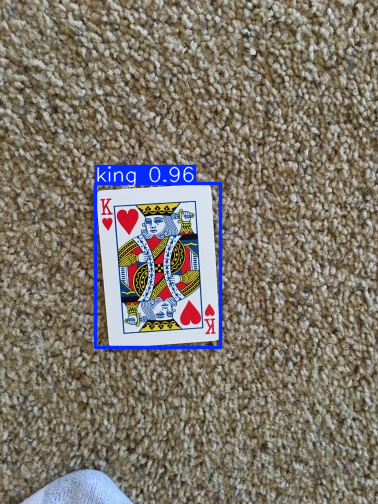

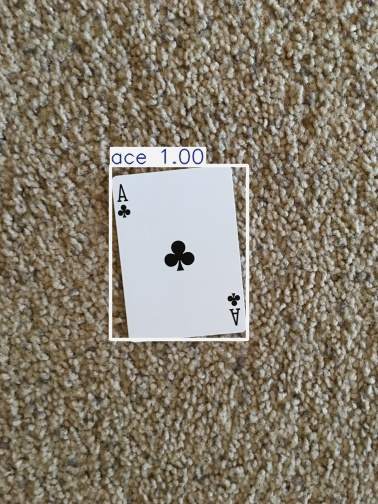

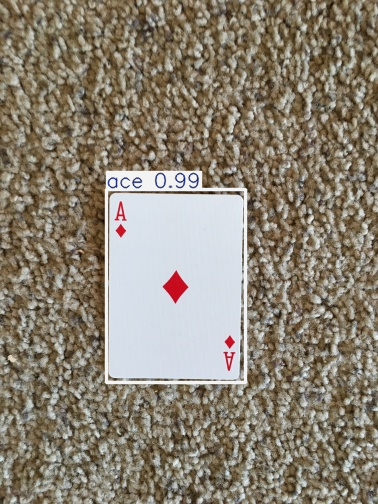

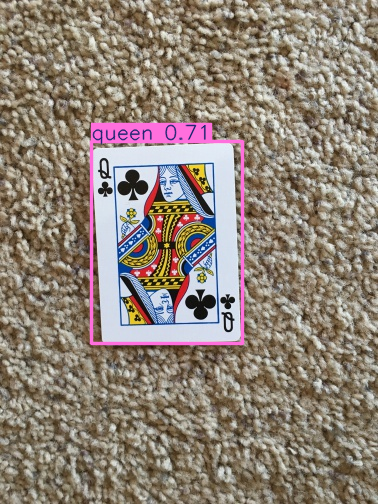

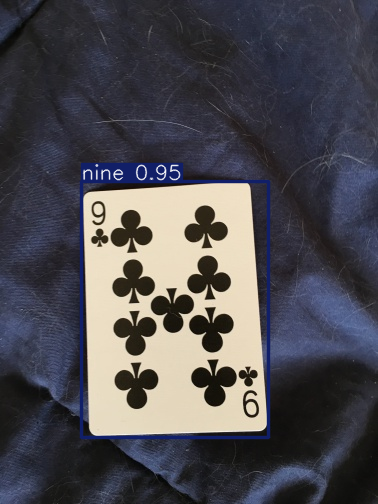

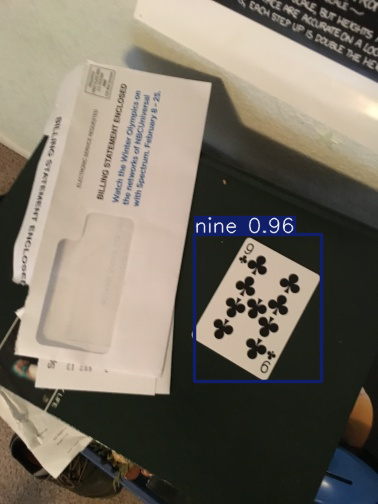

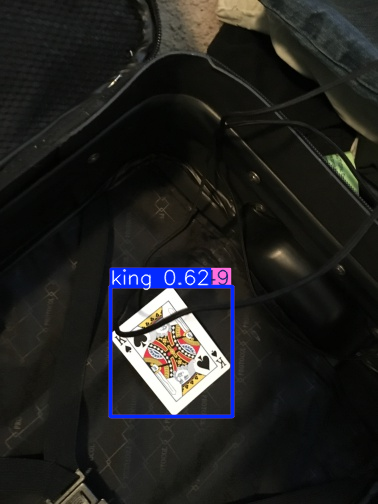

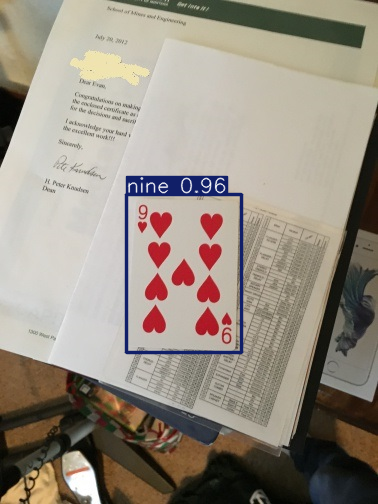

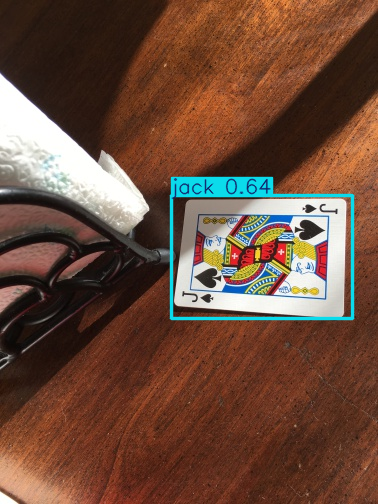

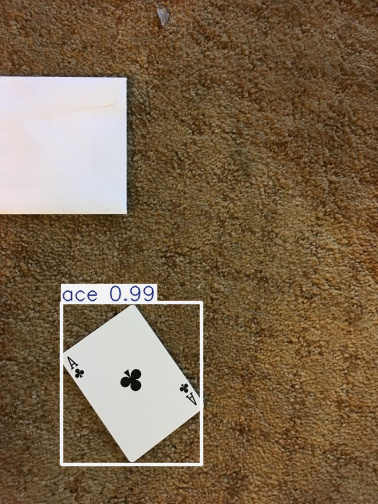

In [29]:
model = ultralytics.YOLO('runs/detect/train/weights/best.pt')
results = model.predict(source='valid/images', save=False, verbose=False)

for result in results[:10]:
    result.plot(show=True)